In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
data_path = "/Users/daikexin/pythonProject/CompensatoryMovement/data"

In [5]:
imu_df=pd.read_csv(f'{data_path}/imu.csv')

Use CNN for each task
- Cup placing

In [6]:
imu_cup_df=imu_df[imu_df['task'] == 'Cupplacing']

visualize all accelerometer data

In [8]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Acc_X'], label='Acc_X')
            plt.plot(subset['PacketCounter'], subset['Acc_Y'], label='Acc_Y')
            plt.plot(subset['PacketCounter'], subset['Acc_Z'], label='Acc_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/acc_images', exist_ok=True)
            plt.savefig(f'{data_path}/acc_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

visualize all gyroscope data

In [18]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Gyr_X'], label='Gyr_X')
            plt.plot(subset['PacketCounter'], subset['Gyr_Y'], label='Gyr_Y')
            plt.plot(subset['PacketCounter'], subset['Gyr_Z'], label='Gyr_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/gyr_images', exist_ok=True)
            plt.savefig(f'{data_path}/gyr_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

visualize all magnetometer data

In [20]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Mag_X'], label='Mag_X')
            plt.plot(subset['PacketCounter'], subset['Mag_Y'], label='Mag_Y')
            plt.plot(subset['PacketCounter'], subset['Mag_Z'], label='Mag_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/mag_images', exist_ok=True)
            plt.savefig(f'{data_path}/mag_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

visualize all quaternions data 

In [21]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Quat_W'], label='Quat_W')
            plt.plot(subset['PacketCounter'], subset['Quat_X'], label='Quat_X')
            plt.plot(subset['PacketCounter'], subset['Quat_Y'], label='Quat_Y')
            plt.plot(subset['PacketCounter'], subset['Quat_Z'], label='Quat_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/quat_images', exist_ok=True)
            plt.savefig(f'{data_path}/quat_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

start to use cnn

In [67]:
# Function to extract condition from filename
def extract_condition(file_name):
    # Conditions to look for in the filename (can add more if needed)
    conditions = ['natural', 'comp', 'comp_WE']
    
    # Iterate through the conditions and check if they are present in the filename
    for condition in conditions:
        if condition in file_name:
            return condition
    
    # If no condition is found, raise an error or return a default
    raise ValueError(f"Condition not found in filename: {file_name}")

In [68]:
# Path to folder containing all images
acc_folder = f"{data_path}/acc_images" 
gyr_folder = f"{data_path}/gyr_images"     
mag_folder = f"{data_path}/mag_images"    
quat_folder = f"{data_path}/quat_images" 

# Parameters
img_width, img_height = 128, 128  # Resize all images to 128x128
batch_size = 32
epochs = 20

In [69]:
# Step 2: Combine the sensor data into 4 channels
images_combined = []
for acc_img, gyro_img, mag_img, quat_img in zip(acc_images, gyro_images, mag_images, quat_images):
    # Stack the 4 sensor modalities along the last axis to form a 4-channel image
    combined_img = np.stack((acc_img, gyro_img, mag_img, quat_img), axis=-1)
    images_combined.append(combined_img)

# Convert to NumPy array
images_combined = np.array(images_combined)

In [70]:
# Step 3: Encode labels
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(labels)

In [71]:
# Step 4: Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_combined, labels_encoded, test_size=0.2, random_state=42, stratify=labels)

ValueError: Found input variables with inconsistent numbers of samples: [75, 300]

In [62]:
# Step 4: Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(labels_encoded.shape[1], activation='softmax')  # Output layer
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/Users/daikexin/pythonProject/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.2396 - loss: 1.6463 - val_accuracy: 0.3333 - val_loss: 1.3199
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3472 - loss: 1.2706 - val_accuracy: 0.3333 - val_loss: 1.1142
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3146 - loss: 1.1144 - val_accuracy: 0.3333 - val_loss: 1.1041
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3049 - loss: 1.1177 - val_accuracy: 0.3333 - val_loss: 1.0992
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.2938 - loss: 1.0974 - val_accuracy: 0.4000 - val_loss: 1.0986
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3694 - loss: 1.0952 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3681 - loss: 1.0986 - val_accuracy: 0.2667 - val_loss: 1.0990
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3264 - loss: 1.0983 - val_accuracy: 0.4667 - val_loss:

In [64]:
# Step 6: Save the trained model
model.save("cnn_condition_classifier.h5")

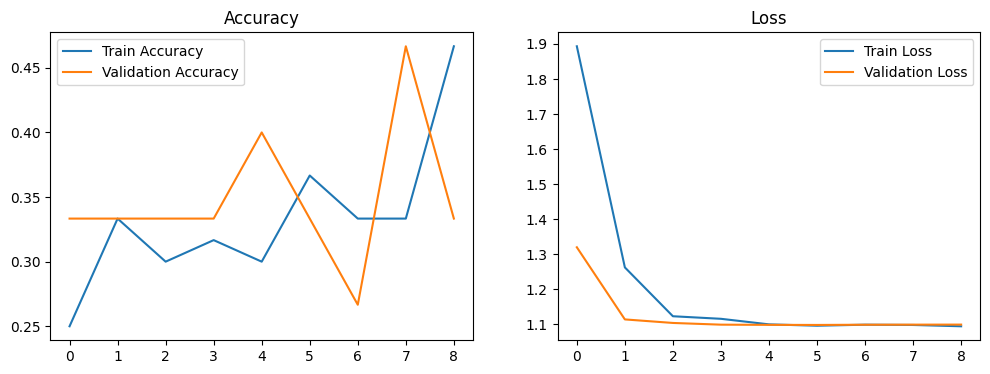

In [65]:
# Step 7: Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [66]:
# Step 8: Evaluate the model
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
class_labels = label_binarizer.classes_

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Classification Report:
              precision    recall  f1-score   support

        comp       0.00      0.00      0.00         5
     comp_WE       0.33      1.00      0.50         5
     natural       0.00      0.00      0.00         5

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15

Confusion Matrix:
[[0 5 0]
 [0 5 0]
 [0 5 0]]


/Users/daikexin/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daikexin/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daikexin/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz